In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_small, PDB_closed, PSF, DCD
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm
from MDAnalysis.analysis.encore.dimensionality_reduction import DimensionalityReductionMethod as drm
from MDAnalysis.analysis import distances, encore, contacts, diffusionmap, align, rms
from pmda.rms import RMSF

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
traj_path = '/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/'
u = mda.Universe(traj_path + '4nsc_A_0.15CA_30ns_gromacs/md.gro', traj_path + '4nsc_A_0.15CA_30ns_gromacs/md.xtc')

In [ ]:
# Interacción MCU ---> 106 107 110 111 114 117 121
# Interacción EMRE ---> 126 129
# Interacción MICU2 ---> 352
# Interfase I ---> 242 253 221 231 225 229
# Interfase I ---> 383 385 427 398 386
# Sitios de unión a Ca2+ ---> 231 235 237 242 
#                        ---> 421 425 427 432
#                        ---> ¿200 196 185 138 199 139?

In [ ]:
rmss=[]
for i in range(len(u.trajectory)):
    try:
        LID_ca = u.select_atoms('resid 56635', updating=True)
        NMP_ca = u.select_atoms('protein', updating=True)
        u.trajectory.next()
        n_LID = len(LID_ca)
        n_NMP = len(NMP_ca)
        # print('LID has {} atoms and NMP has {} atoms'.format(n_LID, n_NMP))
        dist_arr = distances.distance_array(LID_ca.positions, # reference
                                            NMP_ca.positions, # configuration
                                            box=u.dimensions)
        df = pd.DataFrame([NMP_ca.resnums,NMP_ca.resnames,NMP_ca.names,dist_arr[0]]).T
        df.columns=['res_position','res_name','atom_name','distances']
        rms=[]
        contact=pd.DataFrame()
        for j in [200, 196, 185, 138, 199, 139]:
            dfj = df[df['res_position']==j].reset_index()
            contact=contact.append(dfj.iloc[pd.to_numeric(dfj.loc[:,'distances']).idxmin(),:])
            rms =+ (min(df[df['res_position']==j]['distances']))**2
        rmss.append((rms/6)**(1/2))
#         print(contact)
    except StopIteration:
        plt.plot(rmss)
        exit(2)

### Iones en contacto con la proteína

In [ ]:
resid_list = u.select_atoms('resname CA', updating=True).resids
for ca_resid in [56610,56591,56561,56671]:
    print(ca_resid)
    rmss=pd.DataFrame()
    for i in range(len(u.trajectory)):
        try:
            LID_ca = u.select_atoms('resid ' + str(ca_resid), updating=True)
            NMP_ca = u.select_atoms('protein', updating=True)
            u.trajectory.next()
            n_LID = len(LID_ca)
            n_NMP = len(NMP_ca)
            dist_arr = distances.distance_array(LID_ca.positions, # reference
                                                NMP_ca.positions, # configuration
                                                box=u.dimensions)
            frame=[i]*7622
            df = pd.DataFrame([frame,NMP_ca.resnums,NMP_ca.resnames,NMP_ca.names,dist_arr[0]]).T
            df.columns=['frame','res_position','res_name','atom_name','distances']
            rmss=rmss.append(df[pd.to_numeric(df['distances'])<5])
#             rmss=rmss.append(df.iloc[pd.to_numeric(df.loc[:,'distances']).idxmin(),:])
        except StopIteration:
#             plt.plot(rmss)
#             plt.savefig('/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/ca_distances/' + str(ca_resid))
            exit(2)
    rmss.to_csv('/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/' + str(ca_resid) + '.csv')

### Plot de distancia ion/proteina

In [ ]:
ca_dist_folder= traj_path + 'ca_distances/'
# for file in os.listdir(ca_dist_folder):
for file in [56610,56591,56561,56671,56542,56665,56635,56653]:
    plt.figure()
    plt.plot(pd.read_csv(ca_dist_folder + str(file) + '.csv')['distances'])
    plt.title(file)
    plt.show()

### Residuos en contacto con iones de interés

In [ ]:
ca_dist_folder= traj_path + 'ca_distances/'
for i in [56542,56665,56635,56653]:
# for i in [56610,56591,56561,56671,56542,56665,56635,56653]:
    df=pd.read_csv(ca_dist_folder + str(i) + '.csv')
    df_contact = df[df['distances']<5]
    pd.set_option('display.max_rows', None)
#     print(i,df_contact)
    print(i,df_contact.drop_duplicates(subset='res_position'))
    # list(df_contact['res_position'].drop_duplicates())

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(dist_arr, origin='upper')

# add residue ID labels to axes
tick_interval = 5
ax.set_yticks(np.arange(n_LID)[::tick_interval])
ax.set_xticks(np.arange(n_NMP)[::tick_interval])
ax.set_yticklabels(LID_ca.resids[::tick_interval])
ax.set_xticklabels(NMP_ca.resids[::tick_interval])

# add figure labels and titles
plt.ylabel('LID')
plt.xlabel('NMP')
plt.title('Distance between alpha-carbon')

# colorbar
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Distance (Angstrom)')

### Contact analysis: number of contacts within a cutoff

In [ ]:
sel_basic = "(resid 56635)"
sel_acidic = "(resname ASP GLU)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

In [ ]:
def contacts_within_cutoff(u, group_a, group_b, radius=4.5):
    timeseries = []
    for ts in u.trajectory:
        # calculate distances between group_a and group_b
        dist = contacts.distance_array(group_a.positions, group_b.positions)
        # determine which distances <= radius
        n_contacts = contacts.contact_matrix(dist, radius).sum()
        timeseries.append([ts.frame, n_contacts])
    return np.array(timeseries)

In [ ]:
ca1 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=4.5)
# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()
# print number of averave contacts
ca1.timeseries

In [ ]:
ca1.timeseries.shape

In [ ]:
ca = contacts_within_cutoff(u, acidic, basic, radius=4.5)
ca_df = pd.DataFrame(ca, columns=['Frame',
                                  '# Contacts'])
ca_df.tail()

In [ ]:
ca_df.plot(x='Frame')
plt.ylabel('# salt bridges')

In [ ]:
mda.analysis.contacts.q1q2(u, select='protein', radius=4.5)

### Contact analysis: mapa de contactos

In [ ]:
import mdtraj as md
import numpy as np
from __future__ import print_function
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
# Enviroment variable
XTC = '/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/4nsc_A_0.15CA_30ns_gromacs/md.xtc'
PDB = '/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/4nsc_A_0.15CA_30ns_gromacs/4nscA_model_3.pdb'

In [ ]:
traj = md.load(XTC, top = PDB)
print('Frames: %d  Atoms: %d  Dimentions: %d\n' % traj.xyz.shape)
print('Time steps: %d ps' % (traj.time[1] - traj.time[0])) # pico second

In [ ]:
topology = traj.topology
print('MD imformation: %s\n' % topology)
print('All residues: %s\n' % 
      [residue for residue in traj.topology.residues])
# Select the sidechain of first residue in structure
selection = topology.select("(resid %d) and sidechain" % 0)
print('The sidechian coordinates of first residue:\n')
for i in traj.xyz[0, selection, :]:
    print(i)

In [ ]:
def calc_residue_dist(residues = (0, 0)):
    """
    Return the C-alpha distance between two residues.
    """
    diff_vector  = residues[0] - residues[1]
    return np.sqrt(np.vdot(diff_vector, diff_vector))
    
def calc_side_center_mass(topology, frame): 
    """
    Return approximate center of mass of each side chain.
    COM od Glycine is approximated by the coordinate of its CA atom.
    """
    scmass = []
    
    for i in range(0, topology.n_residues):
        selection = topology.select("(resid %d) and sidechain" % i)
        if len(selection) < 1:
            selection = topology.select("(resid %d) and (name CA)" % i)
        mass = np.array([0.0, 0.0, 0.0])
        for atom in selection:
            mass += traj.xyz[frame, atom, :]
        scmass.append(mass/len(selection))
    return scmass
def calc_residue_side_dist(frame, residue_one, residue_two):
    """
    Return the C-alpha distance between two residues.
    """
    # Select first residue
    selection1 = topology.select("(resid %d) and sidechain" % residue_one)
    if len(selection1) < 1:
        selection1 = topology.select("(resid %d) and (name CA)" % residue_one)
    # Select second residue
    selection2 = topology.select("(resid %d) and sidechain" % residue_two)
    if len(selection2) < 1:
        selection2 = topology.select("(resid %d) and (name CA)" % residue_two)
    
    return min( map(calc_residue_dist, [(x,y) for x in traj.xyz[frame, selection1, :] \
                                        for y in traj.xyz[frame, selection2, :]])  )
def calc_matrix_cm(trj, frame, threshold = 0.8, distance = 1.2):
        """
        Used internally to compute the matrix data when the object is
        initialized.
        """
        selection = trj.topology.select('name CA')
        scmass = calc_side_center_mass(trj.topology, frame)
        dim = len(selection)
        
        matrix = np.zeros((len(selection), len(selection)))#, np.bool)
        for row, atom1 in enumerate(selection):
            for col, atom2 in enumerate(selection):
                # Only calculate once
                if col > row - 1:
                    continue
                
                # the atom pointprint(traj.xyz[0, atom, :])
                val = calc_residue_dist(residues = (traj.xyz[frame, atom1, :], traj.xyz[frame, atom2, :]))
                # Center of mass
                
                dis = calc_residue_dist((scmass[col], scmass[row]))
                 
                matrix[row, col] = val < threshold
                
                if dis < distance: 
                    matrix[col, row] = 1 - dis/distance
                else: 
                    matrix[col, row] = 0                
                    
        return matrix
    
def calc_matrix_dis(trj, frame, threshold = 0.8, distance = (0.5, 1.2)):
        """
        Used internally to compute the matrix data when the object is
        initialized.
        """
        selection = trj.topology.select('name CA')
        scmass = calc_side_center_mass(trj.topology, frame)
        dim = len(selection)
        
        matrix = np.zeros((len(selection), len(selection)))#, np.bool)
        for row, atom1 in enumerate(selection):
            for col, atom2 in enumerate(selection):
                # Only calculate once
                if col > row - 1:
                    continue
                
                # the atom pointprint(traj.xyz[0, atom, :])
                val = calc_residue_dist(residues = (traj.xyz[frame, atom1, :], traj.xyz[frame, atom2, :]))
                # closest distance of sidechains
                dis = calc_residue_side_dist(frame, row, col) 
                
                matrix[row, col] = val < threshold
                
                if dis < distance[0]: 
                    matrix[col, row] = 1
                elif distance[0] < dis < distance[1]: 
                    matrix[col, row] = (distance[1] - dis)/(distance[1] - distance[0])
        return matrix

In [ ]:
ef draw(matrix, fig=None, cmap = 'binary', interpolation = 'nearest', colorbar = True, contour = False):
        """
        Creates a matplotlib figure representing the map's matrix.  An existing
        figure can be provided to be drawn on, otherwise a new figure will be
        created.
        """
        if not fig: fig = Figure()
        ax = fig.add_subplot(111)
        cax = ax.imshow(matrix, cmap = matplotlib.cm.get_cmap(cmap), \
                         interpolation = interpolation, origin="lower")
        #ax.set_title(self.title)
        #ax.set_xlabel(self.xlabel)
        #ax.set_ylabel(self.ylabel)
        if colorbar: 
            cbar = fig.colorbar(cax, cmap = matplotlib.cm.get_cmap(cmap))
        #    cbar.ax.set_ylabel(self.colorbarlabel)
        if contour:
            ax.contour(matrix, cmap = matplotlib.cm.get_cmap(cmap))
        return fig
    
def show(matrix):
    """
    Use pyplot to display the map in an interactive window.  Will block
    until the window is closed.
    """
    import matplotlib.pyplot as plt
    draw(matrix, fig = plt.figure())
    plt.show()    
    
    
def print_figure(matrix, filename="map.png"):
    """
    Generates a plot of the map's data and saves an image at the given
    filename.
    """
    canvas = FigureCanvas(draw(matrix))
    canvas.print_figure(filename)
    
def print_csv(matrix, filename="map.csv"):
    np.savetxt(filename, matrix, delimiter = ',')
    print('Saved matrix as file %s' % filename)

In [ ]:
for i in range(0, 400, 40):
    'Output one contact map per 40 ns from a 400 ns trjactory'
    name = 'dist-map-%dns.png' % (i * 0.05)
    matrix = calc_matrix_dis(trj = traj, frame = i)
    show(matrix = matrix)
    print_figure(matrix, filename = name)
    
    if i > 0: continue
    matrix = calc_matrix_cm(trj = traj, frame = i)
    show(matrix = matrix)
    print_figure(matrix, filename="cm-map.png")
    print_csv(matrix)

## Análisis de contactos del RING

In [12]:
path = '/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/contactos/'
file_contacts = 'align_contacts.tsv'
file_conformational_dependent = 'align_conformational_dependent_cm.csv'

In [13]:
# Interacción MCU ---> 106 107 110 111 114 117 121
# Interacción EMRE ---> 126 129
# Interacción MICU2 ---> 352
# Interfase I ---> 242 253 221 231 225 229
# Interfase I ---> 383 385 427 398 386
# Sitios de unión a Ca2+ ---> 231 235 237 242 
#                        ---> 421 425 427 432
#                        ---> ¿200 196 185 138 199 139?

In [19]:
pos_interes = ['106', '107', '110', '111', '114', '117', '121', '126', '129', '352', '242', '253', '221', '231', '225', '229', '383',
               '385', '427', '398', '386', '231', '235', '237', '242', '421', '425', '427', '432', '200', '196', '185', '138', '199', '139']
cm = pd.read_csv(path+file_conformational_dependent, sep='\t')
cm = cm[cm['Model'].str.contains('6')]
cm[['Chain','Position','','Residue']] = cm['Node'].str.split(':', n=4, expand=True)
cm[cm['Position'].isin(pos_interes)]['Position'].drop_duplicates()

11     106
12     107
25     110
26     111
44     117
65     126
72     129
95     138
97     139
193    185
216    196
228    200
277    221
288    225
297    229
303    231
309    235
327    242
353    253
583    352
653    383
657    385
661    386
686    398
744    421
752    425
756    427
770    432
Name: Position, dtype: object

In [23]:
contacts = pd.read_csv(path+file_contacts, sep='\t')
contacts[['Chain_Source','Position_Source','Residue_Source']] = contacts['Source'].str.split('/', n=3, expand=True)
contacts[['Chain_Target','Position_Target','Residue_Target']] = contacts['Target'].str.split('/', n=3, expand=True)
contacts[contacts['Position_Source'].isin(pos_interes)]

,Source,Interaction,Target,Probability,Chain_Source,Position_Source,Residue_Source,Chain_Target,Position_Target,Residue_Target
273,X/106/PHE,HBOND,X/110/LYS,0.500000,X,106,PHE,X,110,LYS
274,X/106/PHE,VDW,X/110/LYS,0.166667,X,106,PHE,X,110,LYS
275,X/106/PHE,VDW,X/109/ARG,0.166667,X,106,PHE,X,109,ARG
276,X/107/ARG,HBOND,X/111/VAL,0.500000,X,107,ARG,X,111,VAL
277,X/107/ARG,HBOND,X/110/LYS,0.166667,X,107,ARG,X,110,LYS
...,...,...,...,...,...,...,...,...,...,...
1453,X/421/ASP,VDW,X/427/GLU,0.166667,X,421,ASP,X,427,GLU
1471,X/432/GLU,HBOND,X/435/SER,0.166667,X,432,GLU,X,435,SER
1472,X/432/GLU,HBOND,X/436/ILE,0.833333,X,432,GLU,X,436,ILE
1473,X/432/GLU,VDW,X/435/SER,0.500000,X,432,GLU,X,435,SER


In [7]:
contacts['Interaction'].unique()

array(['VDW', 'HBOND', 'PIPISTACK', 'PICATION', 'IONIC', 'PIHBOND'],
      dtype=object)

### Calculating the pairwise RMSD of a trajectory

#### RMSD to itself

In [19]:
traj_path = '/home/lean/Documentos/Lean/Andrea/datos neutralizantes/Ac-Ag/nanonet_3.2/ac_ag_3.2/'
# traj_0CA = mda.Universe(traj_path + 'md_0_1.gro',traj_path + 'md_0_1.xtc')
traj_0CA = mda.Universe(traj_path + 'md_aligned_32AG.pdb')

# Construir la selección basada en el rango de números de átomo
# selection = f"all and (bynum {3669}:{13073})"

# Aplicar la selección y obtener un objeto AtomGroup
# protein = traj_0CA.select_atoms(selection)
# traj_3CA = mda.Universe(traj_path + '4nsc_A_0.15CA_30ns_gromacs/md.gro',traj_path + '4nsc_A_0.15CA_30ns_gromacs/md.xtc')

In [35]:
# Crear una lista para almacenar las coordenadas de los átomos en cada paso de tiempo
trajectory_coordinates = []

# Iterar sobre los frames de la trayectoria y guardar las coordenadas de los átomos seleccionados
for ts in traj_0CA.trajectory:
    # Actualizar las coordenadas de la selección en cada frame
    protein.positions = traj_0CA.atoms.positions[protein.indices]
    # Guardar las coordenadas de la selección en la lista
    trajectory_coordinates.append(protein.positions.copy())

# Convertir la lista de coordenadas en un objeto AtomGroup
trajectory_atoms = mda.Merge(protein.atoms)

# Asignar las coordenadas de la trayectoria a la variable AtomGroup
trajectory_atoms.positions = trajectory_coordinates

In [39]:
mobile = trajectory_atoms
ref = trajectory_atoms

mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
unaligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
print(f"Unaligned RMSD: {unaligned_rmsd:.2f}")

aligner = align.AlignTraj(mobile, ref, select='name CA', in_memory=True).run()

mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
aligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)

print(f"Aligned RMSD: {aligned_rmsd:.2f}")

AttributeError: AtomGroup has no attribute trajectory. 

In [ ]:
matrix = diffusionmap.DistanceMatrix(mobile_ca, select='name CA').run()

In [ ]:
a = matrix.results.dist_matrix
ind = np.unravel_index(np.argmax(a, axis=None), a.shape) 
print(matrix.results.dist_matrix.max(),ind)

In [ ]:
plt.imshow(matrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')

#### RMSD two trajectories 

In [ ]:
prmsd = np.zeros((len(traj_0CA.trajectory),  # y-axis
                  len(traj_3CA.trajectory)))  # x-axis

In [ ]:
for i, frame_open in enumerate(traj_3CA.trajectory):
    r = rms.RMSD(traj_0CA, traj_3CA, select='name C',
                 ref_frame=i).run()
    prmsd[i] = r.results.rmsd[:, -1]  # select 3rd column with RMSD values

In [ ]:
plt.imshow(prmsd, cmap='viridis')
plt.xlabel('Frame (traj_0CA)')
plt.ylabel('Frame (traj_3CA)')
plt.colorbar(label=r'RMSD ($\AA$)')

### Calculating RMSF

In [20]:
# c_alphas = mobile.select_atoms('protein and name CA')
# R = rms.RMSF(c_alphas).run()
c2_alphas = traj_0CA.select_atoms('name CA')
R2 = rms.RMSF(c2_alphas).run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


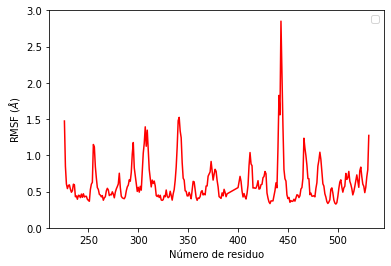

In [21]:
# plt.plot(c_alphas.resids, R.results.rmsf, 'g')
plt.plot(c2_alphas.resids, R2.results.rmsf, 'r')


path = '/home/lean/Documentos/Lean/Andrea/datos neutralizantes/Ac-Ag/'
plt.xlabel('Número de residuo')
plt.ylabel('RMSF ($\AA$)')
# plt.axvspan(96, 109,zorder=0, alpha=0.3, color='orange', label='CDR3')
# plt.axvspan(51, 57, zorder=0, alpha=0.3, color='green', label='CDR2')
# plt.axvspan(26, 33, zorder=0, alpha=0.3, color='blue', label='CDR1')
plt.ylim(0, 3)
plt.legend()
plt.savefig(path + 'RMSF_ag(3.2).png')

In [ ]:
import datetime

fecha_str = "2024-05-09 21:21:26"
fecha = "2024-05-10 03:00:02"
diff = datetime.datetime.strptime(fecha, "%Y-%m-%d  %H:%M:%S") - datetime.datetime.strptime(fecha_str, "%Y-%m-%d  %H:%M:%S")
diff.total_seconds()/3600

## Calculating SASA

In [ ]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import mdtraj as md

In [ ]:
import freesasa

freesasa.h.trajectory

In [ ]:
trajectory = md.load('/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/pdb_from_traj/pares max/4nsc_A_0.15NA_30ns_frame2790.pdb')
sasa = md.shrake_rupley(trajectory)

print(trajectory)
print('sasa data shape', sasa.shape)

In [ ]:
total_sasa = sasa.sum(axis=1)
print(total_sasa)

In [ ]:
sasa

In [ ]:
from matplotlib.pylab import *

plot(trajectory.time, total_sasa)
xlabel('Time [ps]', size=16)
ylabel('Total SASA (nm)^2', size=16)
show()

In [ ]:
def autocorr(x):
    "Compute an autocorrelation with numpy"
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    return result / result[0]

semilogx(trajectory.time, autocorr(total_sasa))
xlabel('Time [ps]', size=16)
ylabel('SASA autocorrelation', size=16)
show()

### Read energy data

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo ener.edr
ener_file = '/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/4nsd_A_3CA_gromacs/md_0_1.edr'

# Crear el objeto Energy
ener = mda.auxiliary.EDR.EDRReader(ener_file)

print(ener.terms)
# Obtener las energías de la simulación
some_terms = ener.get_data(["Potential", "Kinetic En.", "Box-X","Coul-SR:Protein-CA"])
plt.plot(some_terms["Time"], some_terms["Coul-SR:Protein-CA"])

### Trajectory to pdb

In [5]:
path_Na = '/home/lean/Documentos/Lean/SBG/Base_de_calcio/DiversidadConformacionalCBS/MCU/molecular dynamic/'
u = mda.Universe(path_Na + '4nsc_A_0.15NA_30ns_gromacs/md.gro', path_Na + '4nsc_A_0.15NA_30ns_gromacs/md.xtc')
pdb = mda.coordinates.PDB.PDBWriter(path_Na + "4nscNA_500frames.pdb", u, start=1, step=500)
pdb.write_all_timesteps(u)

/home/lean/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1176: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


### RMSF of PDB

In [ ]:
import MDAnalysis as mda
import numpy as np
import os
import matplotlib.pyplot as plt

path = '/home/lean/Documentos/Lean/Andrea/'
# Cargar las dos estructuras PDB
for andrea_ac in os.listdir(path + '7.5_model/'):
    if '5o04' in andrea_ac:
        print(andrea_ac)
        u1 = mda.Universe(path + '7.5_model/' + andrea_ac)
        for hassman_ac in os.listdir(path + 'nano85/'):
            if '5o04' in hassman_ac:
                print(hassman_ac)
                u2 = mda.Universe(path + 'nano85/' + hassman_ac)
                
                # Seleccionar el grupo de átomos de interés (ajusta según tu sistema)
                seleccion = u1.select_atoms("protein and name CA")

                # Obtener las coordenadas de ambas estructuras
                coord1 = u1.select_atoms("protein and name CA").positions[:117]
                coord2 = u2.select_atoms("protein and name CA").positions[:117]

                # Calcular la diferencia RMSF
                rmsf_diff = np.sqrt(np.mean(np.square(coord1 - coord2), axis=1))

                # Graficar la diferencia RMSF
                plt.plot(seleccion.residues.resids[:117], rmsf_diff, label='Diferencia RMSF')
                plt.xlabel('Residuo')
                plt.ylabel('Diferencia RMSF (Å)')
                plt.legend()
                plt.show()

In [ ]:
import MDAnalysis as mda
import numpy as np
import os
import matplotlib.pyplot as plt

path = '/home/lean/Documentos/Lean/glucogenosis/G6P/'
# Cargar las dos estructuras PDB
for andrea_ac in os.listdir(path):
    if 'G6Phuman-WTmodel' in andrea_ac:
        print(andrea_ac)
        u1 = mda.Universe(path + andrea_ac)
        for hassman_ac in os.listdir(path):
            if 'G6Phuman-T16Rmodel' in hassman_ac:
                print(hassman_ac)
                u2 = mda.Universe(path + hassman_ac)
                
                # Seleccionar el grupo de átomos de interés (ajusta según tu sistema)
                seleccion = u1.select_atoms("protein and name CA")

                # Obtener las coordenadas de ambas estructuras
                coord1 = u1.select_atoms("protein and name CA").positions[:117]
                coord2 = u2.select_atoms("protein and name CA").positions[:117]

                # Calcular la diferencia RMSF
                rmsf_diff = np.sqrt(np.mean(np.square(coord1 - coord2), axis=1))

                # Graficar la diferencia RMSF
                plt.plot(seleccion.residues.resids[:117], rmsf_diff, label='Diferencia RMSF')
                plt.xlabel('Residuo')
                plt.ylabel('Diferencia RMSF (Å)')
                plt.legend()
                plt.show()

In [ ]:
rmsf_diff[15]

In [ ]:
from Bio.PDB.Chain import Chain
from Bio.PDB.PDBParser import PDBParser
import warnings
warnings. filterwarnings('ignore')

path='/home/lean/Documentos/Lean/Andrea/modelo_dimero/'
p = PDBParser()
structure=p.get_structure('mypdb',path + 'dimero_modelo_frame0.pdb')
model=structure[0]
my_chain = Chain("A")
model.add(my_chain)
structure